In [1]:
# copy from mnist of exmaple in chainer v4.0
from __future__ import print_function

import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


import os
import numpy as np

In [2]:
train, test = chainer.datasets.get_mnist(ndim=3)

TWO_CLASS = False
if TWO_CLASS:
    index_0and1 = np.logical_or(train._datasets[1] == 0, train._datasets[1] == 1)

    datas = train[index_0and1]

    print(len(datas[1]), len(train._datasets[1]))

    train._datasets = datas
    train._length = len(datas[1])

    index_0and1 = np.logical_or(test._datasets[1] == 0, test._datasets[1] == 1)

    datas = test[index_0and1]

    print(len(datas[1]), len(test._datasets[1]))

    test._datasets = datas
    test._length = len(datas[1])

    print(test[0][0].shape)

In [3]:
train[:2], test[:2]

([(array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.

In [4]:
xs = [1, 2, 3]
len(xs), 2 > len(xs), 3 > len(xs)

(3, False, False)

In [5]:
# Network definition
BATCH_SIZE = 100
from chainer import ChainList, Chain
class SepLink(ChainList):
    def __init__(self, n_separate, link=L.Linear, **kwargs):
        """
            n_separate: 共用変数込みの分割サイズ
            共用, 特定クラス１, 特定クラス２, ...の順番
        """
        super(SepLink, self).__init__()
        self.n_separate = n_separate
        with self.init_scope():
            for i in range(self.n_separate):
                self.add_link(link(**kwargs))
    
    def __call__(self, xs):
        """
            xs: list of variables. eg. [common, specific class 1, specific class 2, ...]
        """
        assert len(xs) > 0
        common_x = xs[0]
        common_y = self[0](common_x)
        ys = [common_y]
        for i in range(1, self.n_separate):
            if i > len(xs) -1:
                x = common_x
            else:
                x = F.concat((common_x, xs[i]), axis=1)
            y = self[i](x)
            ys.append(y)
        return ys

class SepCLF(ChainList):
    def __init__(self, n_specific=2):
        super(SepCLF, self).__init__()
        self.n_specific = n_specific
        with self.init_scope():
            for i in range(self.n_specific):
                self.add_link(L.Linear(None, 1))
    
    def __call__(self, xs):
        assert 1 < len(xs)
        ys = []
        # 共用の結果は抜く
        for i, x in enumerate(xs[1:]):
            h = F.concat([xs[0], x], axis=1)
            ys.append(self[i](h))
        return ys

class SepConvMLP(Chain):

    def __init__(self, in_size, out_size, n_channel=16, n_specific=2):
        super(SepConvMLP, self).__init__()
        with self.init_scope():
#             self.conv1 = L.Convolution2D(in_channels=None, out_channels=n_channel, ksize=3, stride=1)
            self.conv1 = SepLink(n_separate=n_specific+1,
                                 link=L.Convolution2D, in_channels=None, out_channels=n_channel, ksize=3, stride=1)
            self.l1 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
            self.out = SepCLF(n_specific)
        

    def __call__(self, x):
        if not isinstance(x, list):
            x = [x]
#         h = list(map(self.conv1, x))
#         h = list(map(F.relu, h))
        h = list(map(F.relu, self.conv1(x)))
        h1 = list(map(F.relu, self.l1(h)))
        outs = self.out(h1)
        out = F.concat(outs, axis=1)
        return out

class ConvMLP(Chain):
    def __init__(self, in_size, out_size, n_channel=16, n_specific=2):
        super(ConvMLP, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, n_channel, ksize=3, stride=1)
            self.l1 = L.Linear(None, out_size)
            self.out = L.Linear(None, n_specific)
    
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h1 = F.relu(self.l1(h))
        out = self.out(h1)
        return out

In [6]:
def main():
#     parser = argparse.ArgumentParser(description='Chainer example: MNIST')
#     parser.add_argument('--batchsize', '-b', type=int, default=100,
#                         help='Number of images in each mini-batch')
#     parser.add_argument('--epoch', '-e', type=int, default=20,
#                         help='Number of sweeps over the dataset to train')
#     parser.add_argument('--frequency', '-f', type=int, default=-1,
#                         help='Frequency of taking a snapshot')
#     parser.add_argument('--gpu', '-g', type=int, default=-1,
#                         help='GPU ID (negative value indicates CPU)')
#     parser.add_argument('--out', '-o', default='result',
#                         help='Directory to output the result')
#     parser.add_argument('--resume', '-r', default='',
#                         help='Resume the training from snapshot')
#     parser.add_argument('--unit', '-u', type=int, default=1000,
#                         help='Number of units')
#     args = parser.parse_args()
    args_batchsize = BATCH_SIZE
    args_epoch = 50
    args_frequency = -1
    args_gpu = 0
    args_out = 'result_sepconv_seplinear_2Layer_all_class'
    args_unit = int(2**2)
    vanilla_train = True
    
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    print('GPU: {}'.format(args_gpu))
    print('# unit: {}'.format(args_unit))
    print('# Minibatch-size: {}'.format(args_batchsize))
    print('# epoch: {}'.format(args_epoch))
    print('')
    n_specific = 10
    n_channel = 16

    # Set up a neural network to train
    # Classifier reports softmax cross entropy loss and accuracy at every
    # iteration, which will be used by the PrintReport extension below.
    in_size = None
    out_size = args_unit
    model = L.Classifier(ConvMLP(in_size, int(out_size*(n_specific+1)), n_channel=n_channel, n_specific=n_specific))
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    if vanilla_train:
        print('training vanilla')
        chainer.serializers.save_npz(args_out +'/vanilla-base.model', model)
        trainer.run()
        chainer.serializers.save_npz(args_out +'/vanilla.model', model)

    args_out = 'sep_'+ args_out
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    model = L.Classifier(SepConvMLP(in_size, out_size, n_channel=n_channel, n_specific=n_specific))
    print(model.predictor.l1.n_separate)
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    print('training two separated model')
    chainer.serializers.save_npz(args_out +'/sep-base.model', model)
    trainer.run()
    chainer.serializers.save_npz(args_out +'/sep.model', model)

In [7]:
main()

GPU: 0
# unit: 4
# Minibatch-size: 100
# epoch: 50

training vanilla
epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
     total [..................................................]  0.33%
this epoch [########..........................................] 16.67%
       100 iter, 0 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [..................................................]  0.67%
this epoch [################..................................] 33.33%
       200 iter, 0 epoch / 50 epochs
     247.1 iters/sec. Estimated time to finish: 0:02:00.597415.
     total [..................................................]  1.00%
this epoch [#########################.........................] 50.00%
       300 iter, 0 epoch / 50 epochs
    251.01 iters/sec. Estimated time to finish: 0:01:58.322838.
     total [..................................................]  1.33%
this epoch [##########################

     total [#####.............................................] 10.67%
this epoch [################..................................] 33.33%
      3200 iter, 5 epoch / 50 epochs
    207.05 iters/sec. Estimated time to finish: 0:02:09.434237.
     total [#####.............................................] 11.00%
this epoch [#########################.........................] 50.00%
      3300 iter, 5 epoch / 50 epochs
    208.21 iters/sec. Estimated time to finish: 0:02:08.236448.
     total [#####.............................................] 11.33%
this epoch [#################################.................] 66.67%
      3400 iter, 5 epoch / 50 epochs
     209.3 iters/sec. Estimated time to finish: 0:02:07.088702.
     total [#####.............................................] 11.67%
this epoch [#########################################.........] 83.33%
      3500 iter, 5 epoch / 50 epochs
    210.33 iters/sec. Estimated time to finish: 0:02:05.993513.
6           0.0125216   0.05

     total [##########........................................] 21.00%
this epoch [#########################.........................] 50.00%
      6300 iter, 10 epoch / 50 epochs
    208.97 iters/sec. Estimated time to finish: 0:01:53.414056.
     total [##########........................................] 21.33%
this epoch [#################################.................] 66.67%
      6400 iter, 10 epoch / 50 epochs
    209.53 iters/sec. Estimated time to finish: 0:01:52.633831.
     total [##########........................................] 21.67%
this epoch [#########################################.........] 83.33%
      6500 iter, 10 epoch / 50 epochs
    210.08 iters/sec. Estimated time to finish: 0:01:51.864656.
11          0.00589376  0.0722231             0.998283       0.9812                    35.1263       
     total [###########.......................................] 22.00%
this epoch [..................................................]  0.00%
      6600 iter, 11 epoc

     total [###############...................................] 31.33%
this epoch [#################################.................] 66.67%
      9400 iter, 15 epoch / 50 epochs
    209.68 iters/sec. Estimated time to finish: 0:01:38.245129.
     total [###############...................................] 31.67%
this epoch [#########################################.........] 83.33%
      9500 iter, 15 epoch / 50 epochs
    210.05 iters/sec. Estimated time to finish: 0:01:37.597159.
16          0.00111369  0.0859145             0.999666       0.9821                    49.4135       
     total [################..................................] 32.00%
this epoch [..................................................]  0.00%
      9600 iter, 16 epoch / 50 epochs
    208.29 iters/sec. Estimated time to finish: 0:01:37.941398.
     total [################..................................] 32.33%
this epoch [########..........................................] 16.67%
      9700 iter, 16 epoc

     total [####################..............................] 41.67%
this epoch [#########################################.........] 83.33%
     12500 iter, 20 epoch / 50 epochs
    211.95 iters/sec. Estimated time to finish: 0:01:22.567718.
21          0.00184945  0.0883868             0.999483       0.9833                    63.5601       
     total [#####################.............................] 42.00%
this epoch [..................................................]  0.00%
     12600 iter, 21 epoch / 50 epochs
    209.89 iters/sec. Estimated time to finish: 0:01:22.901081.
     total [#####################.............................] 42.33%
this epoch [########..........................................] 16.67%
     12700 iter, 21 epoch / 50 epochs
    209.85 iters/sec. Estimated time to finish: 0:01:22.438681.
     total [#####################.............................] 42.67%
this epoch [################..................................] 33.33%
     12800 iter, 21 epoc

26          0.000275913  0.0832106             0.999967       0.9848                    77.8331       
     total [##########################........................] 52.00%
this epoch [..................................................]  0.00%
     15600 iter, 26 epoch / 50 epochs
    210.17 iters/sec. Estimated time to finish: 0:01:08.514470.
     total [##########################........................] 52.33%
this epoch [########..........................................] 16.67%
     15700 iter, 26 epoch / 50 epochs
    210.16 iters/sec. Estimated time to finish: 0:01:08.043389.
     total [##########################........................] 52.67%
this epoch [################..................................] 33.33%
     15800 iter, 26 epoch / 50 epochs
    210.16 iters/sec. Estimated time to finish: 0:01:07.568655.
     total [##########################........................] 53.00%
this epoch [#########################.........................] 50.00%
     15900 iter, 26 epo

     total [###############################...................] 62.33%
this epoch [########..........................................] 16.67%
     18700 iter, 31 epoch / 50 epochs
    210.36 iters/sec. Estimated time to finish: 0:00:53.716574.
     total [###############################...................] 62.67%
this epoch [################..................................] 33.33%
     18800 iter, 31 epoch / 50 epochs
    210.35 iters/sec. Estimated time to finish: 0:00:53.244414.
     total [###############################...................] 63.00%
this epoch [#########################.........................] 50.00%
     18900 iter, 31 epoch / 50 epochs
    210.33 iters/sec. Estimated time to finish: 0:00:52.773434.
     total [###############################...................] 63.33%
this epoch [#################################.................] 66.67%
     19000 iter, 31 epoch / 50 epochs
    212.37 iters/sec. Estimated time to finish: 0:00:51.795363.
     total [############

     total [####################################..............] 72.67%
this epoch [################..................................] 33.33%
     21800 iter, 36 epoch / 50 epochs
    209.27 iters/sec. Estimated time to finish: 0:00:39.184282.
     total [####################################..............] 73.00%
this epoch [#########################.........................] 50.00%
     21900 iter, 36 epoch / 50 epochs
    209.27 iters/sec. Estimated time to finish: 0:00:38.705908.
     total [####################################..............] 73.33%
this epoch [#################################.................] 66.67%
     22000 iter, 36 epoch / 50 epochs
    211.29 iters/sec. Estimated time to finish: 0:00:37.862917.
     total [####################################..............] 73.67%
this epoch [#########################################.........] 83.33%
     22100 iter, 36 epoch / 50 epochs
    211.28 iters/sec. Estimated time to finish: 0:00:37.391694.
37          5.24427e-06 

     total [#########################################.........] 83.00%
this epoch [#########################.........................] 50.00%
     24900 iter, 41 epoch / 50 epochs
    209.02 iters/sec. Estimated time to finish: 0:00:24.400046.
     total [#########################################.........] 83.33%
this epoch [#################################.................] 66.67%
     25000 iter, 41 epoch / 50 epochs
    211.03 iters/sec. Estimated time to finish: 0:00:23.693502.
     total [#########################################.........] 83.67%
this epoch [#########################################.........] 83.33%
     25100 iter, 41 epoch / 50 epochs
    211.03 iters/sec. Estimated time to finish: 0:00:23.218900.
42          1.4753e-06  0.0960922             1              0.9863                    123.622       
     total [##########################################........] 84.00%
this epoch [..................................................]  0.00%
     25200 iter, 42 epoc

     total [##############################################....] 93.33%
this epoch [#################################.................] 66.67%
     28000 iter, 46 epoch / 50 epochs
    210.62 iters/sec. Estimated time to finish: 0:00:09.495836.
     total [##############################################....] 93.67%
this epoch [#########################################.........] 83.33%
     28100 iter, 46 epoch / 50 epochs
    210.65 iters/sec. Estimated time to finish: 0:00:09.019629.
47          3.62563e-07  0.103694              1              0.9864                    137.923       
     total [###############################################...] 94.00%
this epoch [..................................................]  0.00%
     28200 iter, 47 epoch / 50 epochs
    208.78 iters/sec. Estimated time to finish: 0:00:08.621523.
     total [###############################################...] 94.33%
this epoch [########..........................................] 16.67%
     28300 iter, 47 epo

     total [#.................................................]  3.67%
this epoch [#########################################.........] 83.33%
      1100 iter, 1 epoch / 50 epochs
    30.186 iters/sec. Estimated time to finish: 0:15:57.396217.
2           0.0697765   0.0751241             0.978983       0.9753                    41.1499       
     total [##................................................]  4.00%
this epoch [..................................................]  0.00%
      1200 iter, 2 epoch / 50 epochs
    28.805 iters/sec. Estimated time to finish: 0:16:39.810729.
     total [##................................................]  4.33%
this epoch [########..........................................] 16.67%
      1300 iter, 2 epoch / 50 epochs
     29.06 iters/sec. Estimated time to finish: 0:16:27.596014.
     total [##................................................]  4.67%
this epoch [################..................................] 33.33%
      1400 iter, 2 epoch / 

7           0.00944774  0.0671737             0.997232       0.9817                    144.905       
     total [#######...........................................] 14.00%
this epoch [..................................................]  0.00%
      4200 iter, 7 epoch / 50 epochs
    28.881 iters/sec. Estimated time to finish: 0:14:53.310710.
     total [#######...........................................] 14.33%
this epoch [########..........................................] 16.67%
      4300 iter, 7 epoch / 50 epochs
    28.951 iters/sec. Estimated time to finish: 0:14:47.693805.
     total [#######...........................................] 14.67%
this epoch [################..................................] 33.33%
      4400 iter, 7 epoch / 50 epochs
     29.02 iters/sec. Estimated time to finish: 0:14:42.163374.
     total [#######...........................................] 15.00%
this epoch [#########################.........................] 50.00%
      4500 iter, 7 epoch / 

     total [############......................................] 24.33%
this epoch [########..........................................] 16.67%
      7300 iter, 12 epoch / 50 epochs
    28.931 iters/sec. Estimated time to finish: 0:13:04.622611.
     total [############......................................] 24.67%
this epoch [################..................................] 33.33%
      7400 iter, 12 epoch / 50 epochs
    28.955 iters/sec. Estimated time to finish: 0:13:00.533459.
     total [############......................................] 25.00%
this epoch [#########################.........................] 50.00%
      7500 iter, 12 epoch / 50 epochs
    28.994 iters/sec. Estimated time to finish: 0:12:56.022480.
     total [############......................................] 25.33%
this epoch [#################################.................] 66.67%
      7600 iter, 12 epoch / 50 epochs
    29.032 iters/sec. Estimated time to finish: 0:12:51.555376.
     total [############

     total [#################.................................] 34.67%
this epoch [################..................................] 33.33%
     10400 iter, 17 epoch / 50 epochs
     28.87 iters/sec. Estimated time to finish: 0:11:18.902723.
     total [#################.................................] 35.00%
this epoch [#########################.........................] 50.00%
     10500 iter, 17 epoch / 50 epochs
    28.857 iters/sec. Estimated time to finish: 0:11:15.743457.
     total [#################.................................] 35.33%
this epoch [#################################.................] 66.67%
     10600 iter, 17 epoch / 50 epochs
    29.017 iters/sec. Estimated time to finish: 0:11:08.567198.
     total [#################.................................] 35.67%
this epoch [#########################################.........] 83.33%
     10700 iter, 17 epoch / 50 epochs
    29.017 iters/sec. Estimated time to finish: 0:11:05.126269.
18          0.00296597  

     total [######################............................] 45.00%
this epoch [#########################.........................] 50.00%
     13500 iter, 22 epoch / 50 epochs
    28.843 iters/sec. Estimated time to finish: 0:09:32.065144.
     total [######################............................] 45.33%
this epoch [#################################.................] 66.67%
     13600 iter, 22 epoch / 50 epochs
    29.007 iters/sec. Estimated time to finish: 0:09:25.385186.
     total [######################............................] 45.67%
this epoch [#########################################.........] 83.33%
     13700 iter, 22 epoch / 50 epochs
    29.017 iters/sec. Estimated time to finish: 0:09:21.729997.
23          0.00221859  0.109359              0.9995         0.9798                    477.117       
     total [#######################...........................] 46.00%
this epoch [..................................................]  0.00%
     13800 iter, 23 epoc

     total [###########################.......................] 55.33%
this epoch [#################################.................] 66.67%
     16600 iter, 27 epoch / 50 epochs
    28.994 iters/sec. Estimated time to finish: 0:07:42.168096.
     total [###########################.......................] 55.67%
this epoch [#########################################.........] 83.33%
     16700 iter, 27 epoch / 50 epochs
    28.994 iters/sec. Estimated time to finish: 0:07:38.719326.
28          4.97932e-05  0.0908512             1              0.9839                    581.153       
     total [############################......................] 56.00%
this epoch [..................................................]  0.00%
     16800 iter, 28 epoch / 50 epochs
    28.832 iters/sec. Estimated time to finish: 0:07:37.817854.
     total [############################......................] 56.33%
this epoch [########..........................................] 16.67%
     16900 iter, 28 epo

     total [################################..................] 65.67%
this epoch [#########################################.........] 83.33%
     19700 iter, 32 epoch / 50 epochs
    28.998 iters/sec. Estimated time to finish: 0:05:55.201694.
33          8.07376e-06  0.0969432             1              0.9848                    684.89        
     total [#################################.................] 66.00%
this epoch [..................................................]  0.00%
     19800 iter, 33 epoch / 50 epochs
    28.834 iters/sec. Estimated time to finish: 0:05:53.743347.
     total [#################################.................] 66.33%
this epoch [########..........................................] 16.67%
     19900 iter, 33 epoch / 50 epochs
    28.835 iters/sec. Estimated time to finish: 0:05:50.266266.
     total [#################################.................] 66.67%
this epoch [################..................................] 33.33%
     20000 iter, 33 epo

38          2.17204e-06  0.10504               1              0.9849                    788.654       
     total [######################################............] 76.00%
this epoch [..................................................]  0.00%
     22800 iter, 38 epoch / 50 epochs
    28.835 iters/sec. Estimated time to finish: 0:04:09.693065.
     total [######################################............] 76.33%
this epoch [########..........................................] 16.67%
     22900 iter, 38 epoch / 50 epochs
    28.836 iters/sec. Estimated time to finish: 0:04:06.216365.
     total [######################################............] 76.67%
this epoch [################..................................] 33.33%
     23000 iter, 38 epoch / 50 epochs
    28.849 iters/sec. Estimated time to finish: 0:04:02.643551.
     total [######################################............] 77.00%
this epoch [#########################.........................] 50.00%
     23100 iter, 38 epo

     total [###########################################.......] 86.33%
this epoch [########..........................................] 16.67%
     25900 iter, 43 epoch / 50 epochs
    28.851 iters/sec. Estimated time to finish: 0:02:22.110911.
     total [###########################################.......] 86.67%
this epoch [################..................................] 33.33%
     26000 iter, 43 epoch / 50 epochs
     28.85 iters/sec. Estimated time to finish: 0:02:18.646114.
     total [###########################################.......] 87.00%
this epoch [#########################.........................] 50.00%
     26100 iter, 43 epoch / 50 epochs
    28.851 iters/sec. Estimated time to finish: 0:02:15.179380.
     total [###########################################.......] 87.33%
this epoch [#################################.................] 66.67%
     26200 iter, 43 epoch / 50 epochs
    28.999 iters/sec. Estimated time to finish: 0:02:11.040626.
     total [############

     total [################################################..] 96.67%
this epoch [################..................................] 33.33%
     29000 iter, 48 epoch / 50 epochs
    28.829 iters/sec. Estimated time to finish: 0:00:34.687197.
     total [################################################..] 97.00%
this epoch [#########################.........................] 50.00%
     29100 iter, 48 epoch / 50 epochs
    28.828 iters/sec. Estimated time to finish: 0:00:31.220065.
     total [################################################..] 97.33%
this epoch [#################################.................] 66.67%
     29200 iter, 48 epoch / 50 epochs
    29.004 iters/sec. Estimated time to finish: 0:00:27.582372.
     total [################################################..] 97.67%
this epoch [#########################################.........] 83.33%
     29300 iter, 48 epoch / 50 epochs
    29.003 iters/sec. Estimated time to finish: 0:00:24.135041.
49          1.97017e-05 

In [8]:
in_size = None
n_specific = 10
n_channel = 16
out_size = int(2**2)
vanilla_model = L.Classifier(ConvMLP(in_size, int(out_size*(n_specific+1)), n_channel=n_channel, n_specific=n_specific))
sep_model = L.Classifier(SepConvMLP(in_size, out_size, n_channel=n_channel, n_specific=n_specific))
chainer.serializers.load_npz('./result_sepconv_seplinear_2Layer_all_class/vanilla.model', vanilla_model)
chainer.serializers.load_npz('./sep_result_sepconv_seplinear_2Layer_all_class/sep.model', sep_model)

In [10]:
van_mlp = vanilla_model.predictor
print(van_mlp.conv1.W.shape, van_mlp.l1.W.shape, van_mlp.out.W.shape)

sep_mlp = sep_model.predictor
for i in range(sep_mlp.conv1.n_separate):
    print(sep_mlp.conv1[i].W.shape)
for i in range(sep_mlp.l1.n_separate):
    print(sep_mlp.l1[i].W.shape)
for i in range(sep_mlp.out.n_specific):
    print(sep_mlp.out[i].W.shape)

(16, 1, 3, 3) (44, 10816) (10, 44)
(16, 1, 3, 3)
(16, 1, 3, 3)
(16, 1, 3, 3)
(16, 1, 3, 3)
(16, 1, 3, 3)
(16, 1, 3, 3)
(16, 1, 3, 3)
(16, 1, 3, 3)
(16, 1, 3, 3)
(16, 1, 3, 3)
(16, 1, 3, 3)
(4, 10816)
(4, 21632)
(4, 21632)
(4, 21632)
(4, 21632)
(4, 21632)
(4, 21632)
(4, 21632)
(4, 21632)
(4, 21632)
(4, 21632)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
van_root = './result_sepconv_seplinear_2Layer_all_class'

1


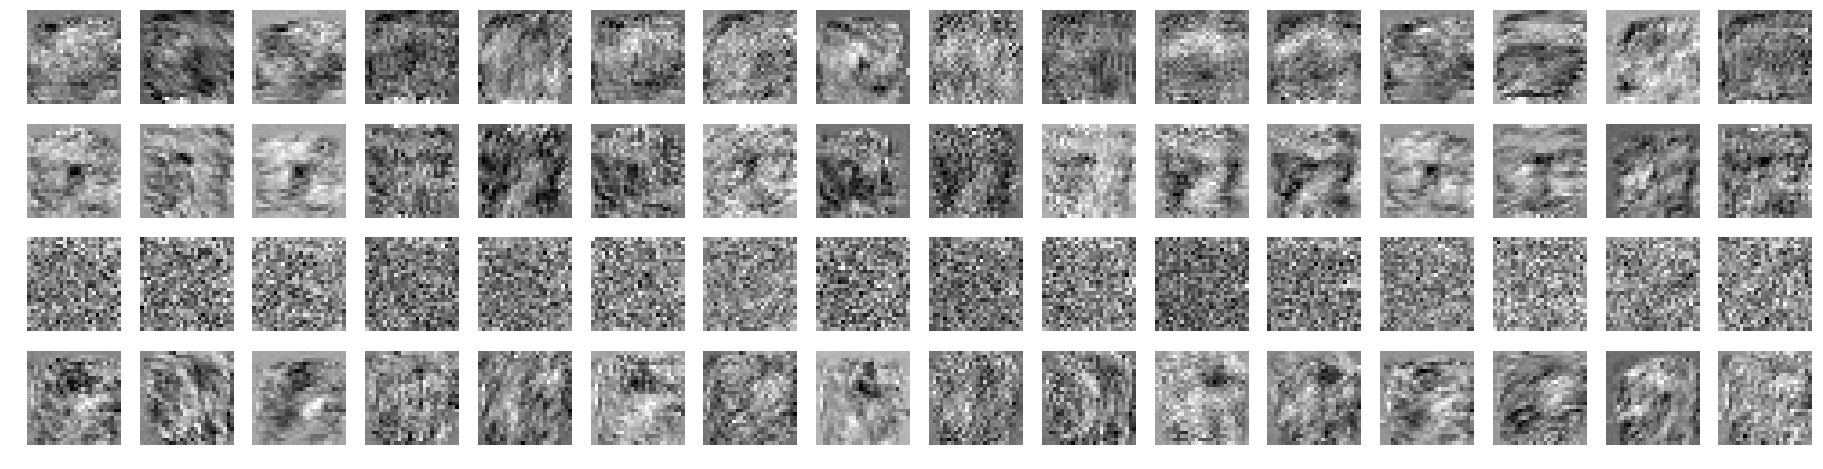

2


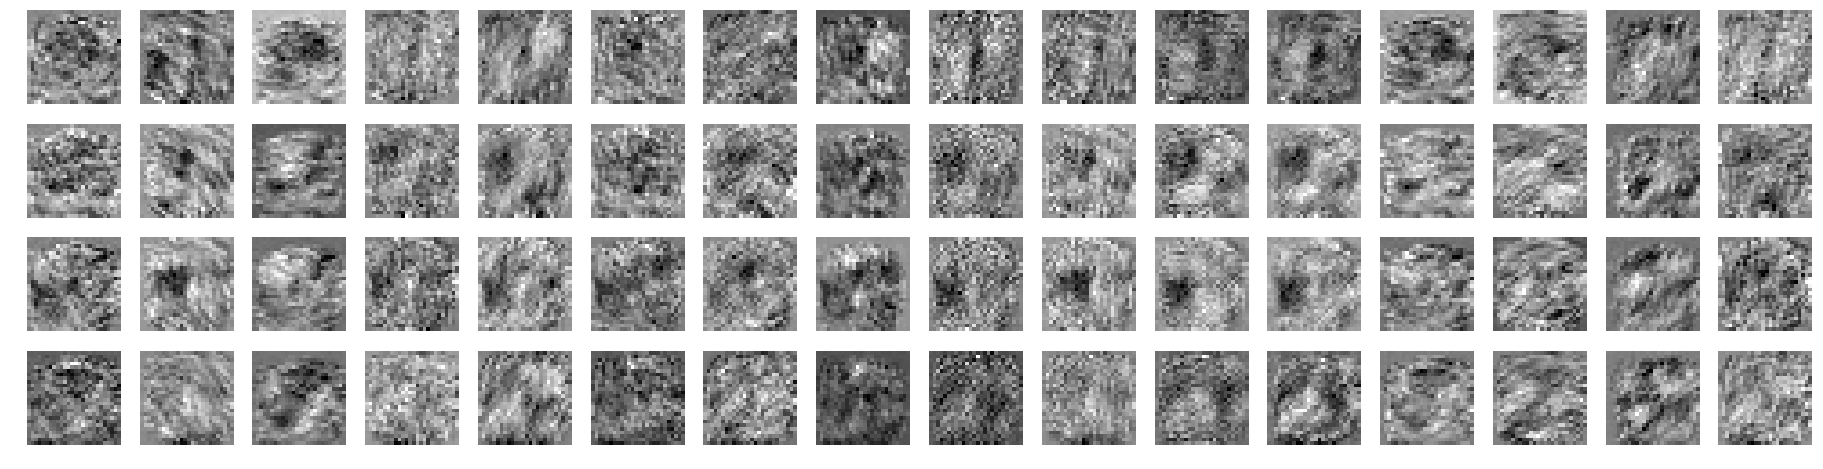

3


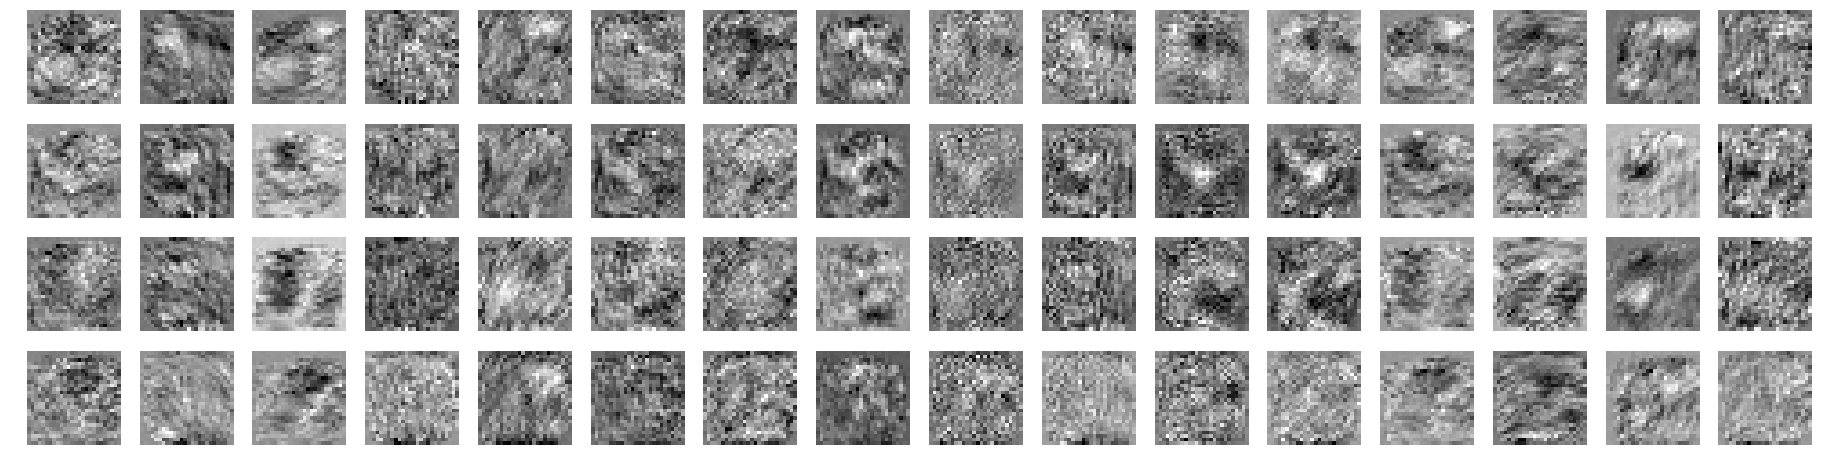

4


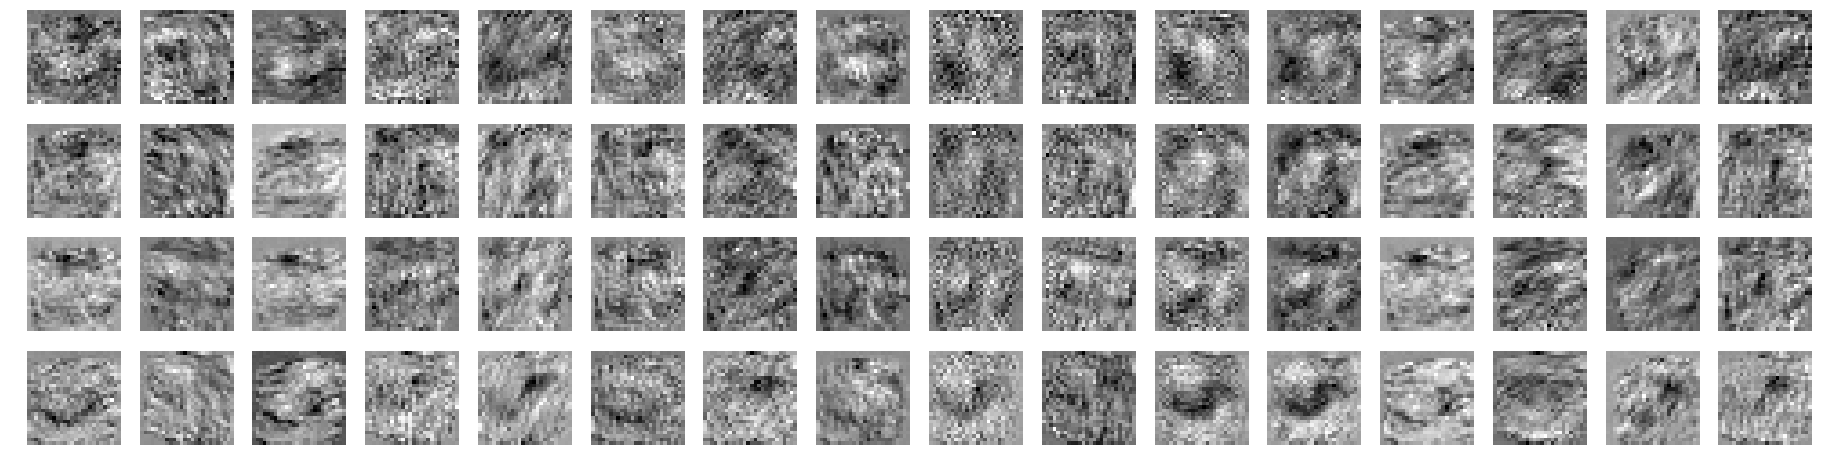

5


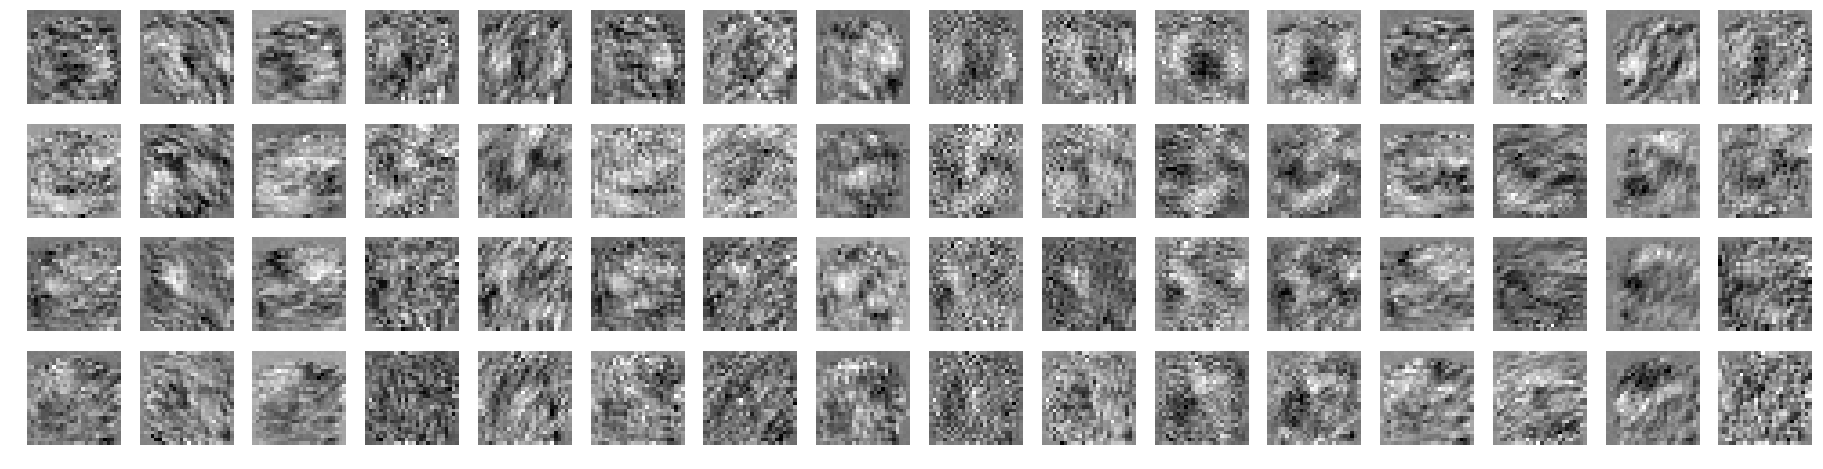

6


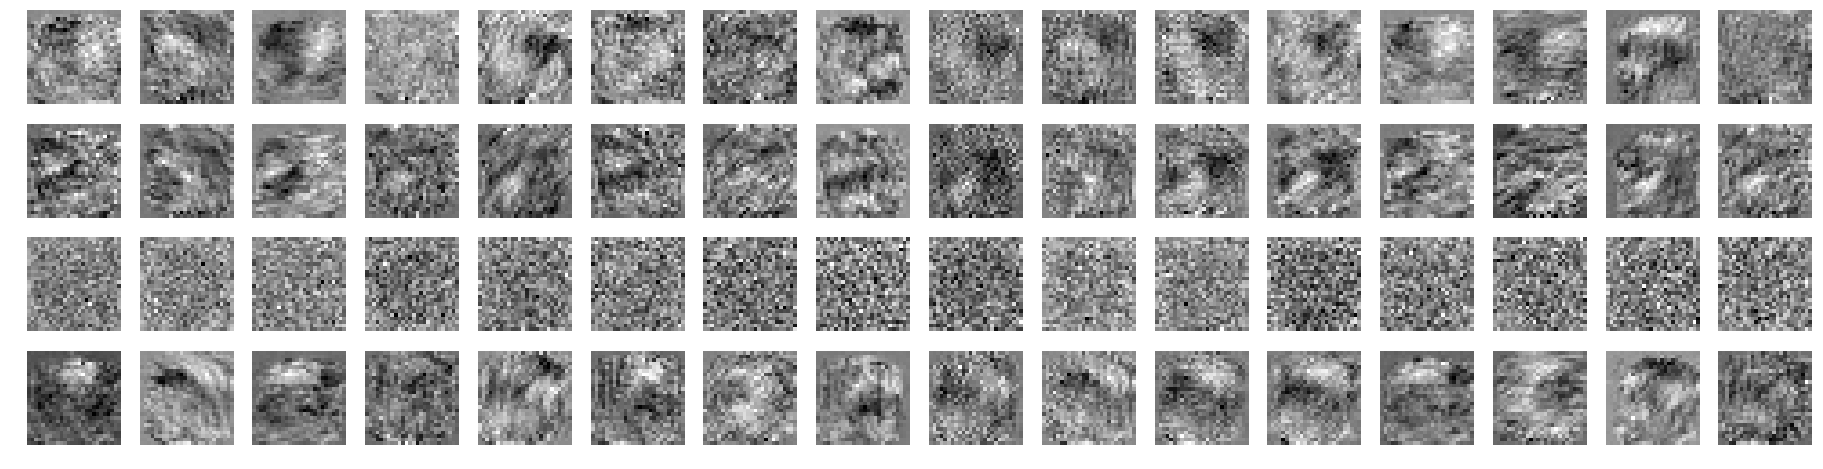

7


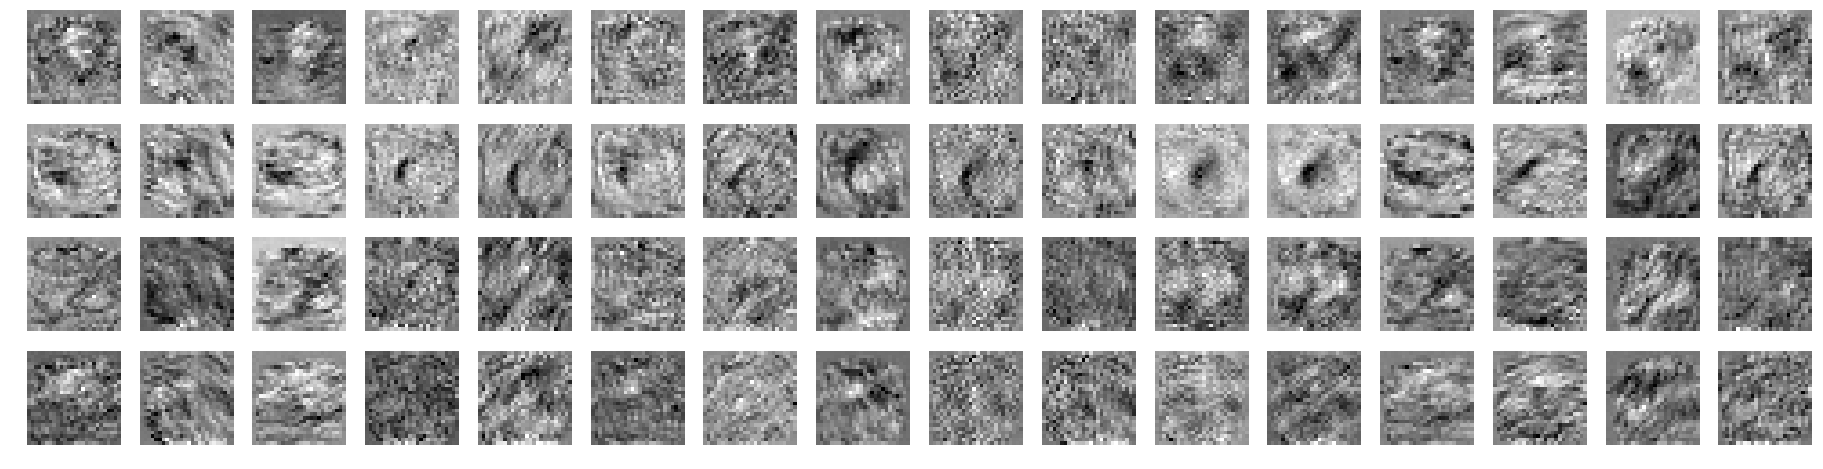

8


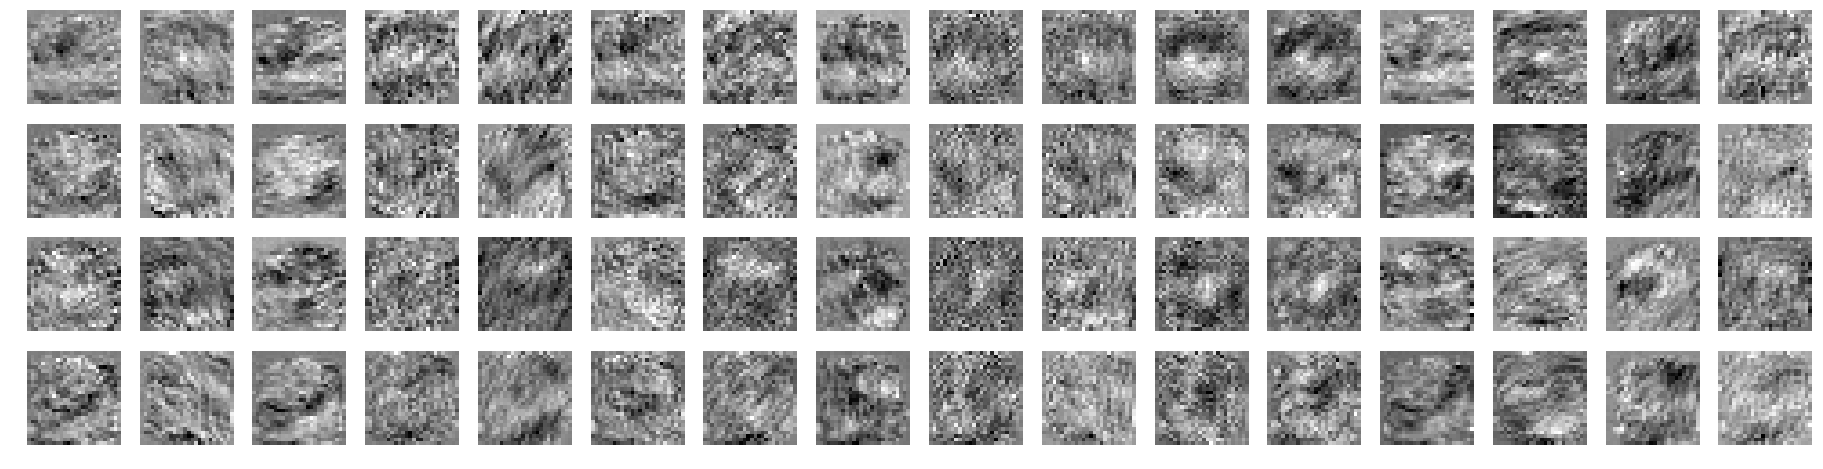

9


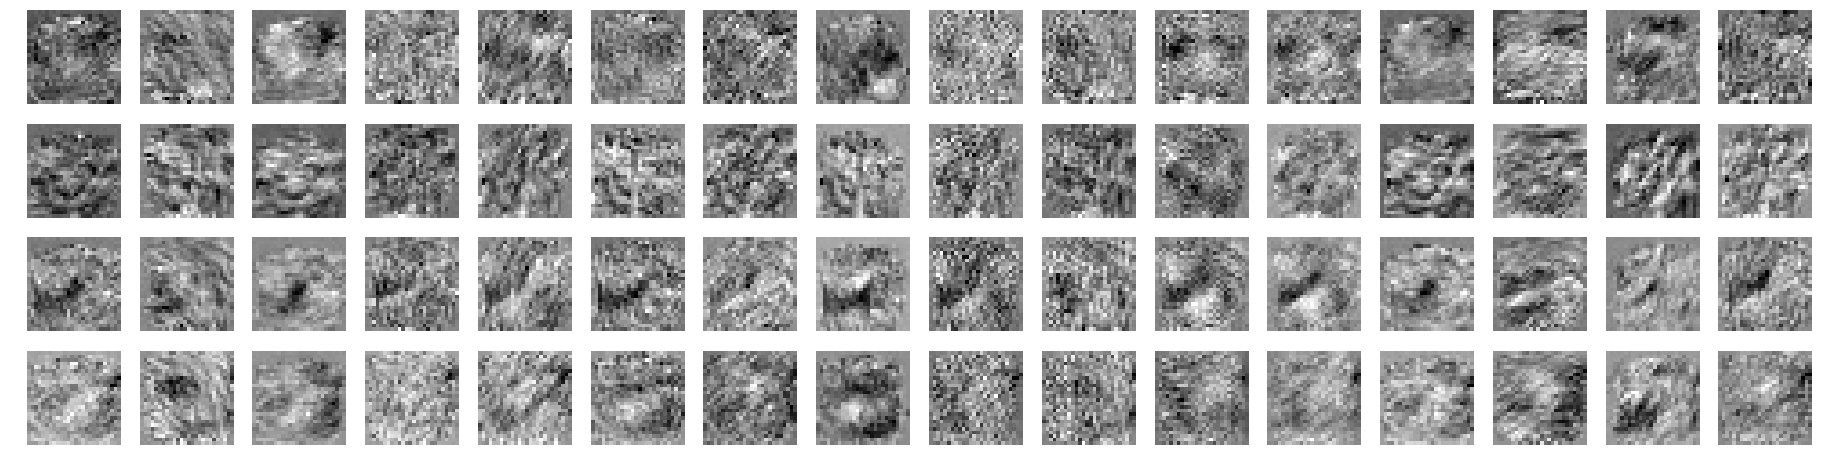

10


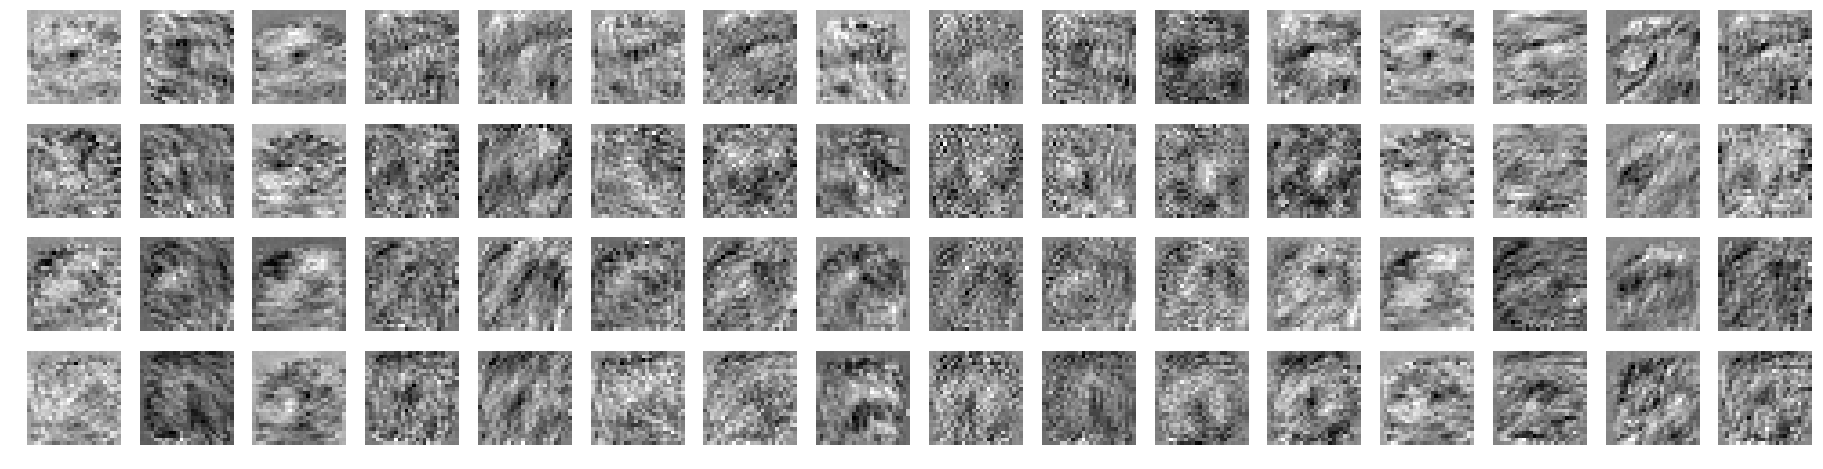

11


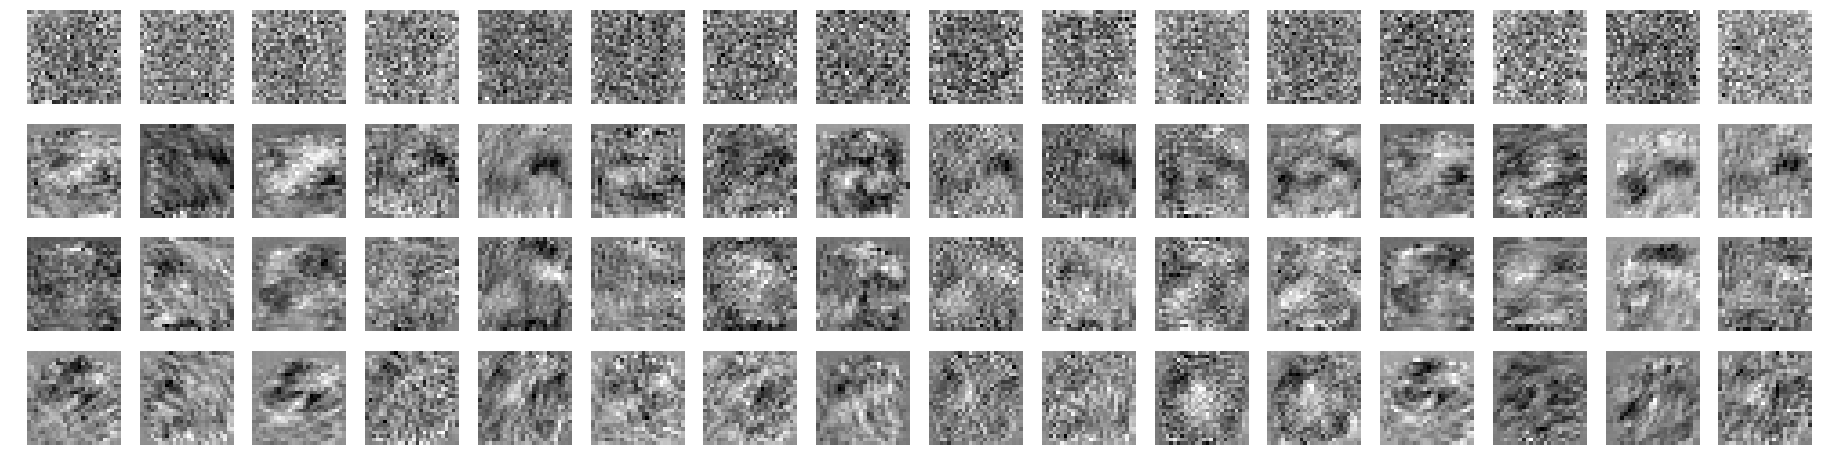

26


In [18]:
n_row = 2
n_col = 2
for i in range(1, n_specific+2):
    print(i)
    plt.figure(figsize=(n_channel*2, n_row*n_col*2))
    for j in range(int(n_row*n_col)):
        w_data = van_mlp.l1.W.data[int(n_col*n_row*(i-1) + j)].reshape(n_channel, -1)
        w = int(np.sqrt(w_data.shape[1]))
        for k in range(n_channel):
            plt.subplot(n_row*n_col, n_channel, n_channel*j+k+1)
            plt.imshow(w_data[k].reshape(w, w), cmap='gray')
            plt.axis('off')
    plt.savefig(os.path.join(van_root, 'l1_weights_{}.png'.format(i-2)))
    plt.show()
print(w)

In [16]:
sep_root = './sep_result_sepconv_seplinear_2Layer_all_class'

1
common


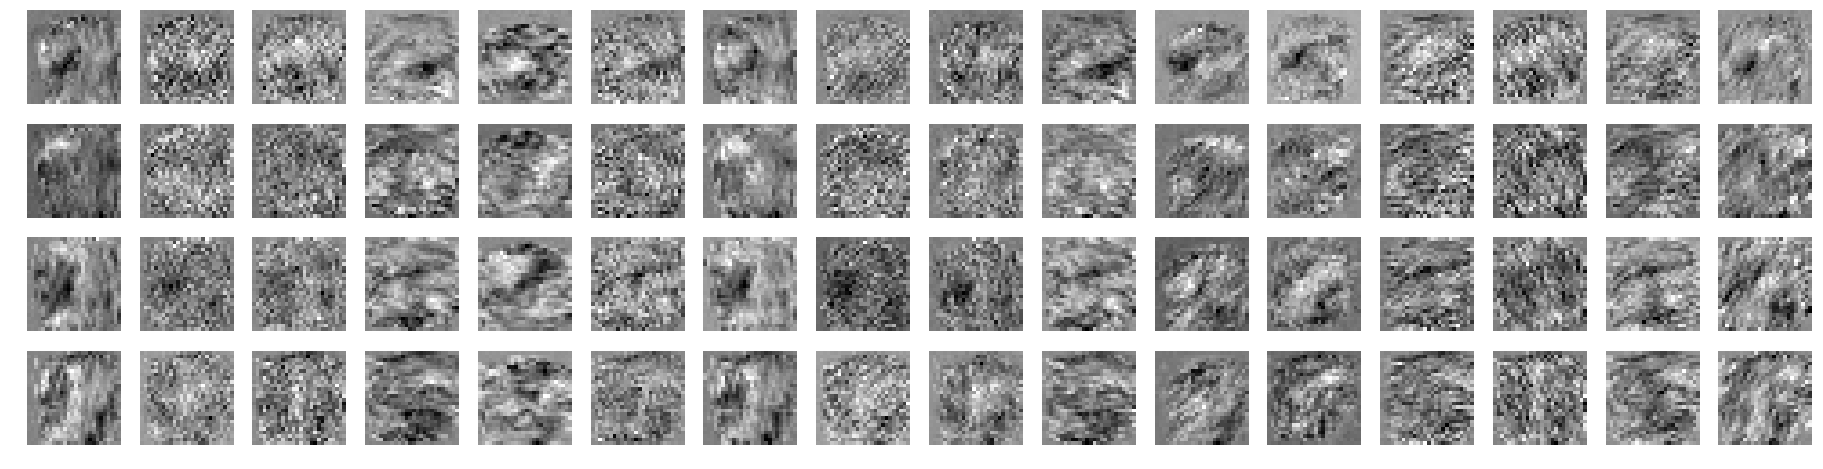

2
specific


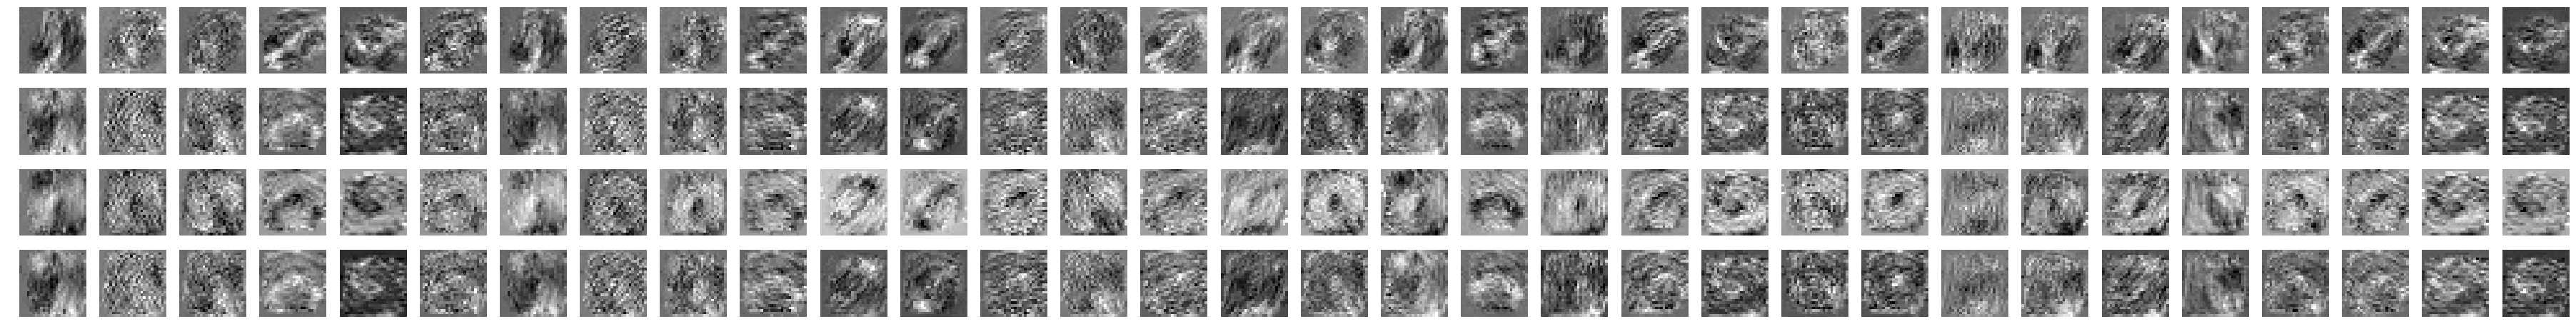

3
specific


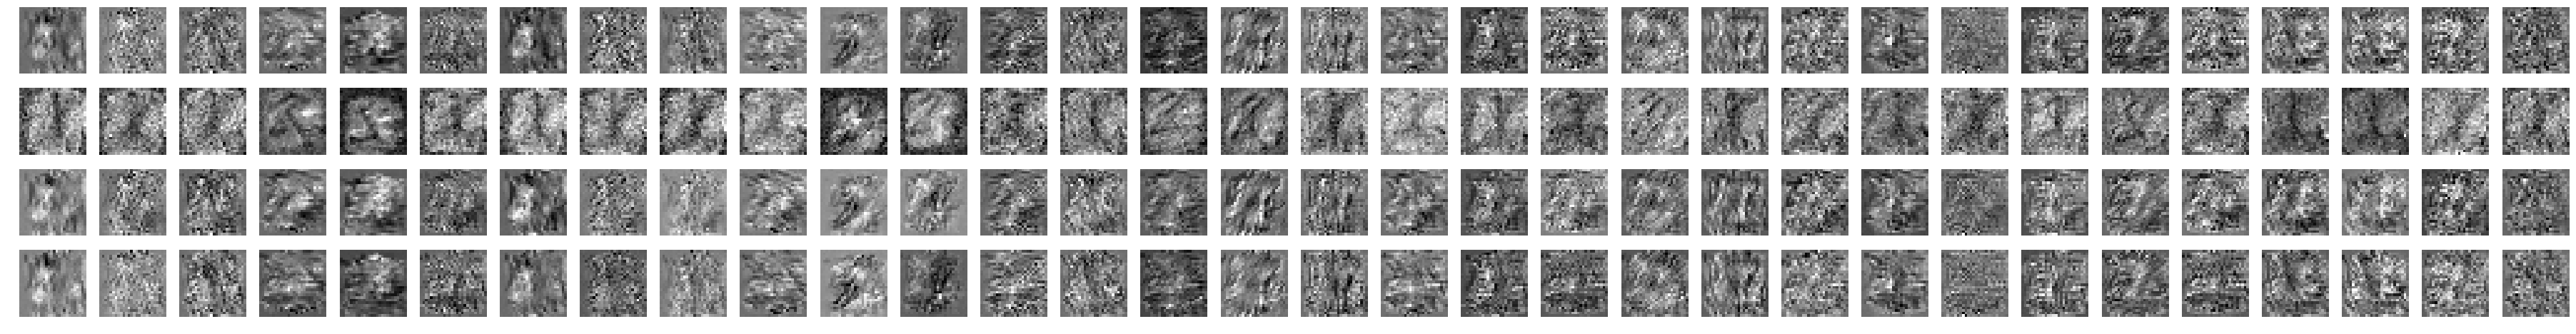

4
specific


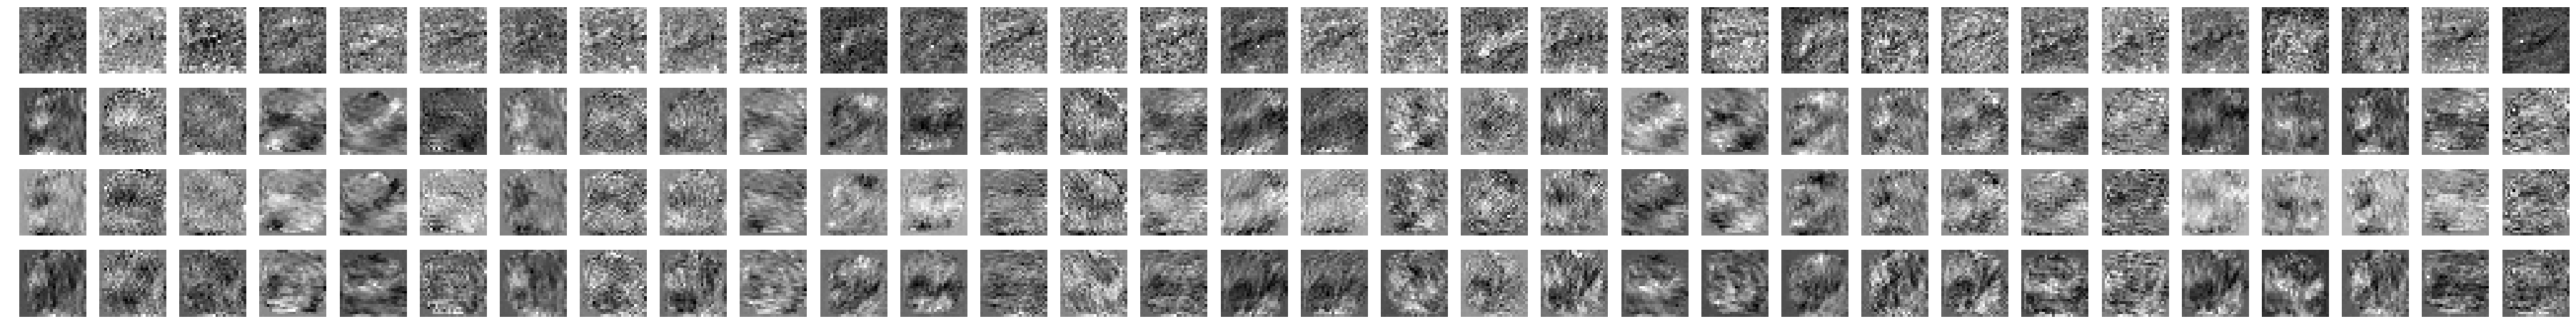

5
specific


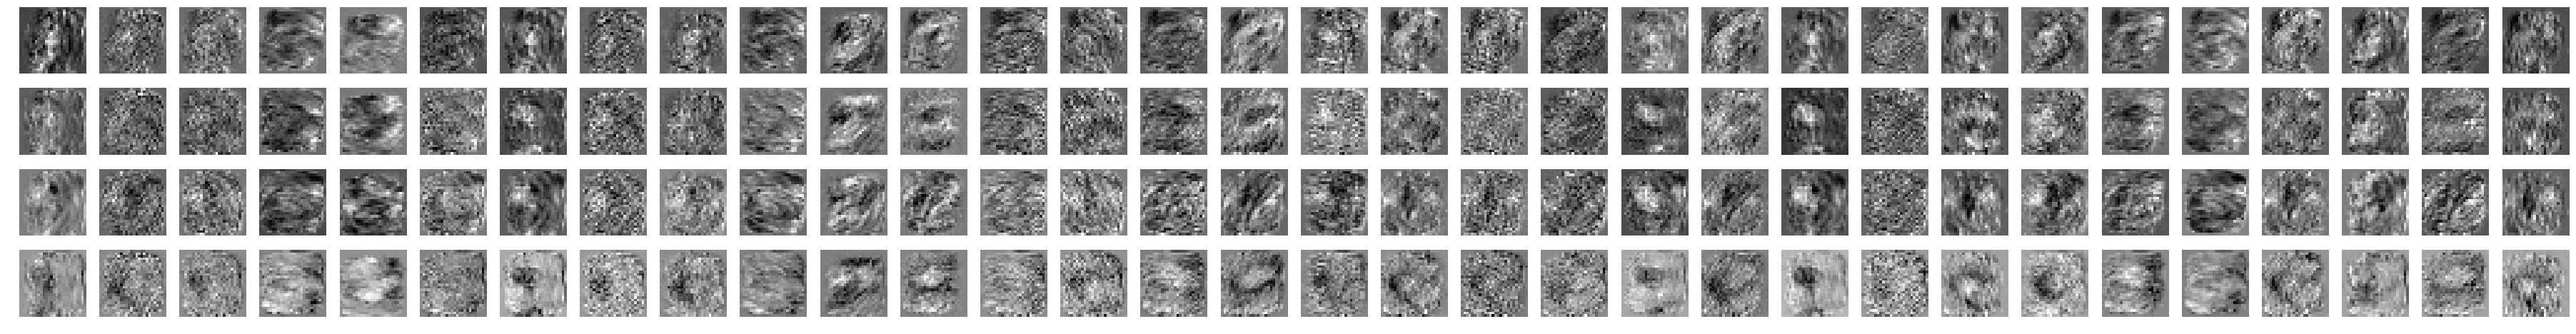

6
specific


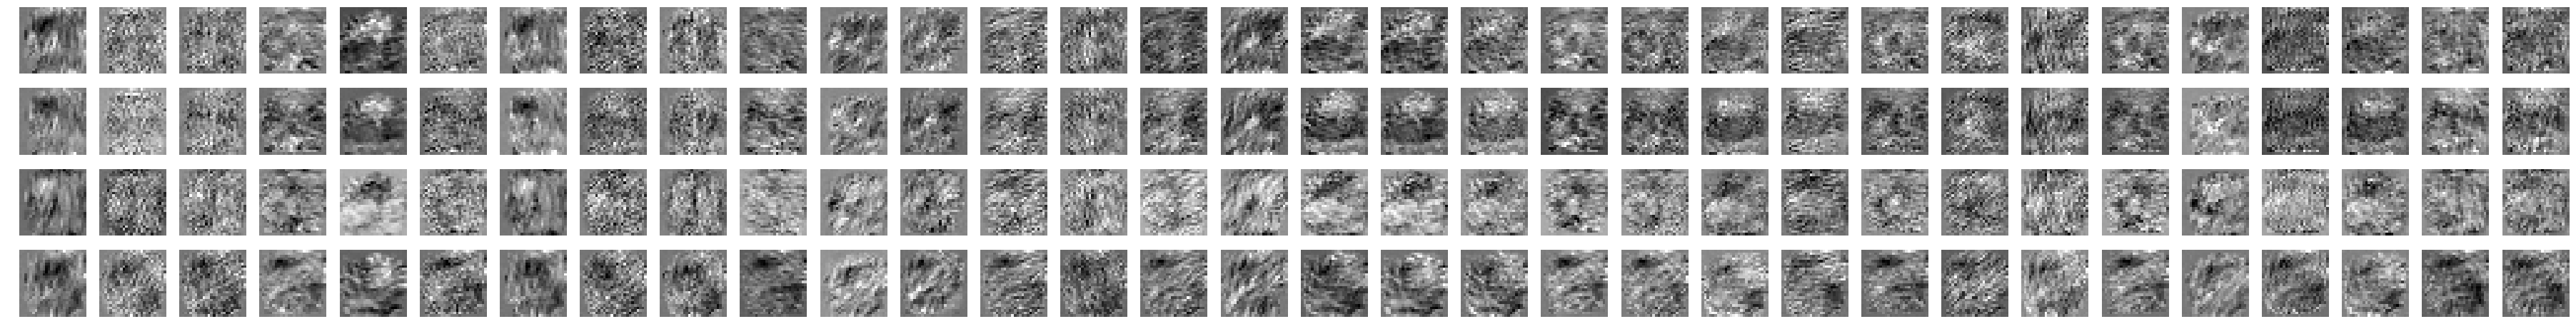

7
specific


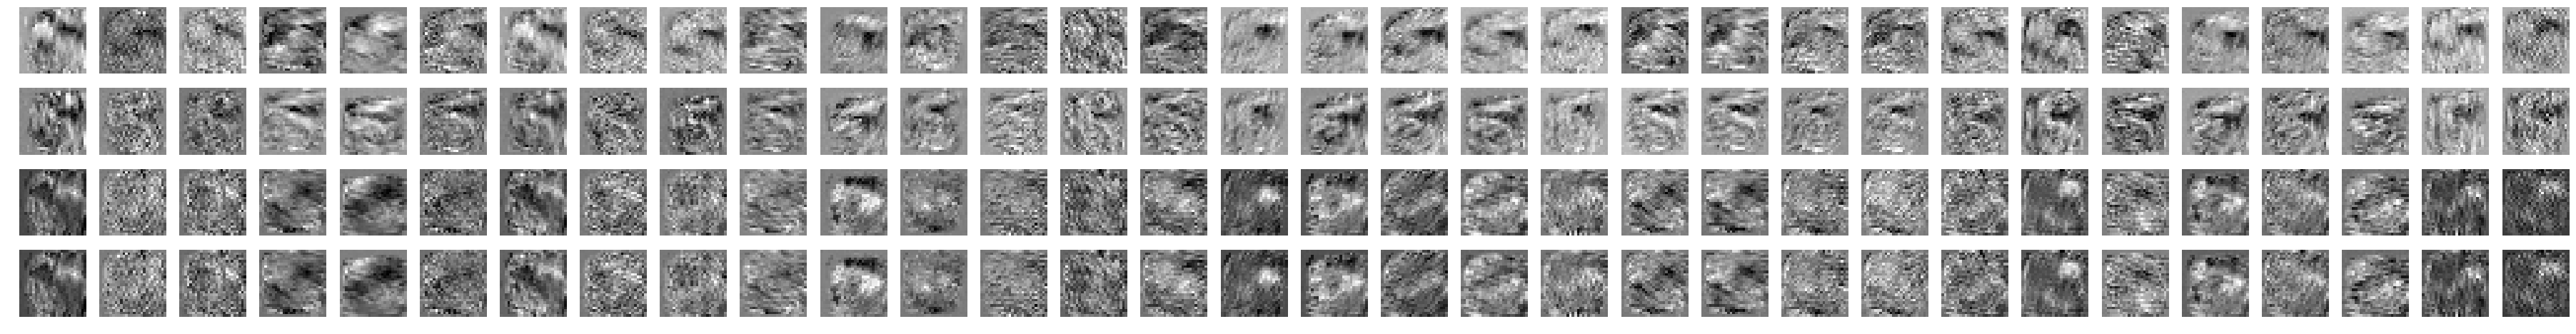

8
specific


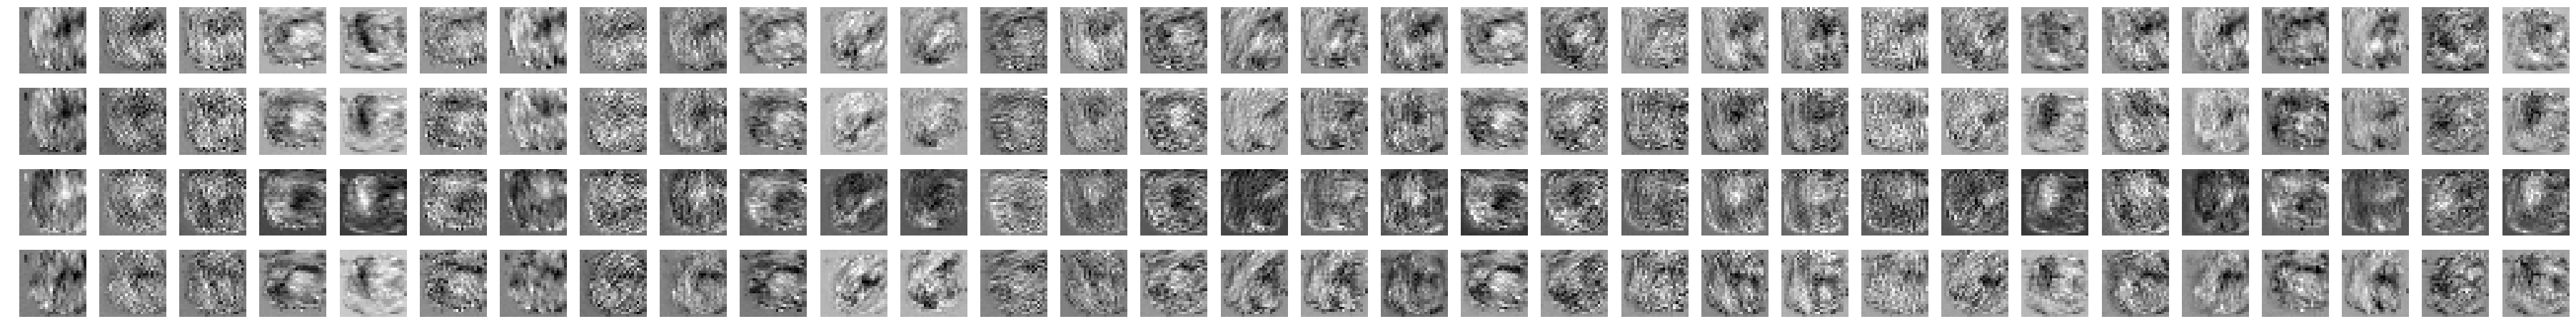

9
specific


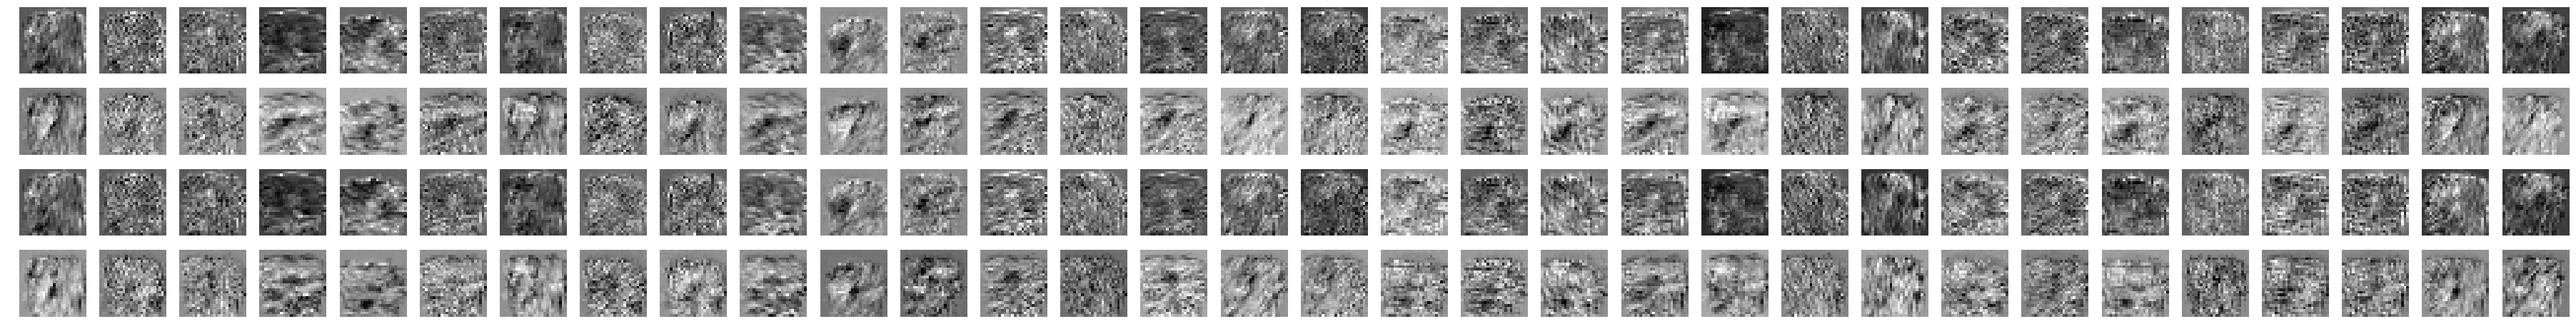

10
specific


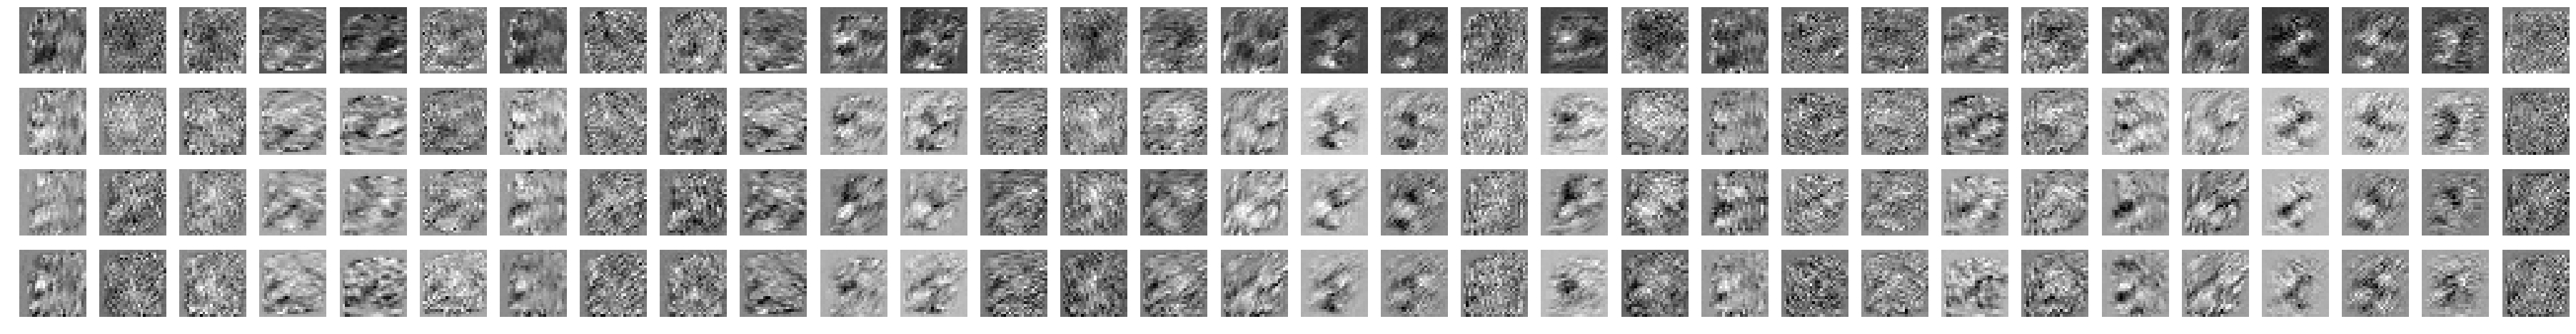

11
specific


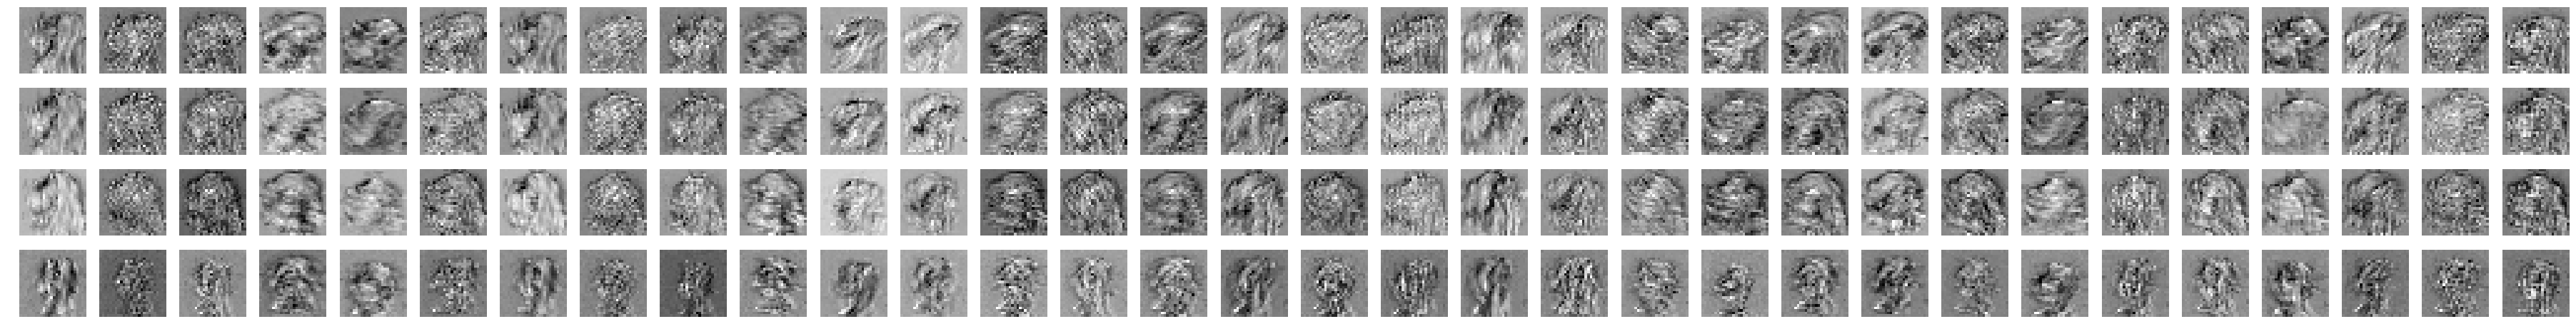

In [20]:
n_row = 2
n_col = 2
for i in range(1, n_specific+2):
    print(i)
    if i == 1:
        print('common')
        channel = n_channel
    else:
        print('specific')
        channel = n_channel*2
    plt.figure(figsize=(channel*2, n_col*n_row*2))
    for j in range(int(n_row*n_col)):
        for k in range(channel):
            plt.subplot(n_row*n_col, channel, channel*j+k+1)
            w_data = sep_mlp.l1[i-1].W.data[int(j)].reshape(channel, -1)
            plt.imshow(w_data[k].reshape(w, w), cmap='gray')
            plt.axis('off')
    plt.savefig(os.path.join(sep_root, 'l1_weights_{}.png'.format(i-2)))
    plt.show()

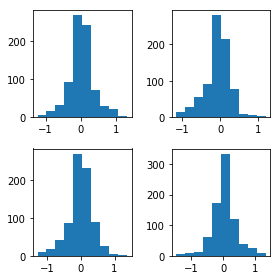

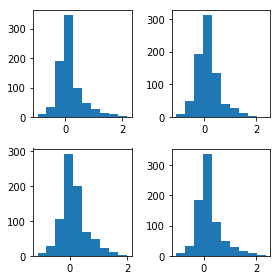

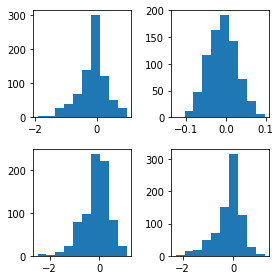

In [49]:
n_row = 2
n_col = 2
for i in range(1, 3+1):
    plt.figure(figsize=(n_row*2, n_col*2))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
#         plt.imshow(van_mlp.l1.W.data[int(i*j)].reshape(28, 28), cmap='gray')
        plt.hist(sep_mlp.l1[i-1].W.data[int(j)])
#         plt.axis('off')
    plt.tight_layout()
    plt.show()

[[ 0.07511211  0.33531988  0.40708542 -0.68301105  0.00328134 -0.68353224
   0.21231079 -1.0464522  -0.9086151  -0.8725519  -0.4447089   0.38888735
  -0.7736789  -1.0607717   0.14264907  0.58373135  0.57107544  0.6682275
   0.4980798   0.69106174  0.29699603 -0.7963526   0.36554676  0.3125569
   0.7543513   0.01029655 -1.3206228  -1.6611751   0.10166971  0.1588697
  -0.5953785  -1.9610044   0.14823233 -0.888133    0.5102823   0.6501202
  -0.17094052 -0.17793491 -0.49797457 -1.161644   -0.4852531  -0.91022396
   0.00591887 -0.14262256]
 [-0.90086365  0.45420754 -0.35489154  0.97859913  0.22747114 -0.52779496
   0.7086523   0.7515534  -0.4587842   0.46605688  0.22349167  0.10608526
   0.11557005  0.5479687  -0.37464646  0.6515495  -1.5335735  -0.23404586
  -0.5106779   0.9967213   0.01650159 -1.1066607  -0.03073386 -0.98250425
   0.78447145 -0.23993245  0.49877933  1.245224   -0.20851888 -0.1936512
  -0.07824962  0.27488235 -0.41445112 -0.03139648  0.947627    0.78036827
  -1.4235144   0

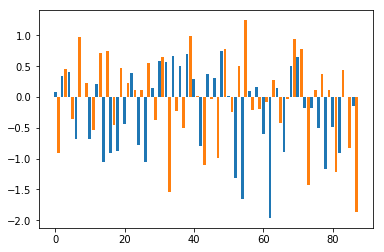

In [51]:
print(van_mlp.out.W.data)
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*2, van_mlp.out.W.data[0])
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*2+1, van_mlp.out.W.data[1])
plt.show()

[[ 1.0835652   0.2627686   0.2597404   0.65377265 -1.1378077  -1.2105938
  -1.9634953  -0.85829264]]


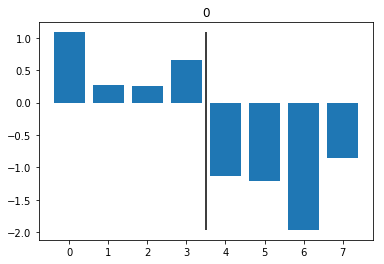

[[-0.04425191  0.6031764  -1.0220748   0.00788897  1.7333212   0.7146446
   2.0009592   1.6573801 ]]


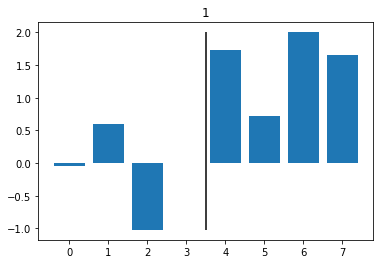

[[ 0.22923388 -0.14085384 -0.8324088   0.15716775  2.3785477   1.3899862
   1.8260113   1.846473  ]]


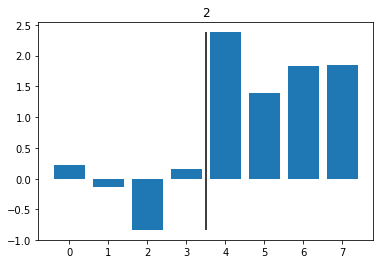

[[-0.5598392 -1.2951247 -0.1702604 -0.8759753 -2.0772948  0.9704017
   1.9808725  2.171578 ]]


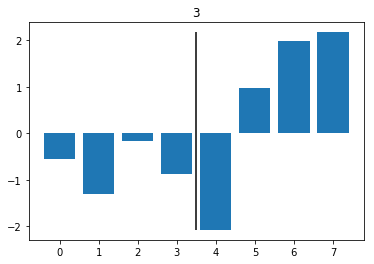

[[ 1.0126594   0.10185392  0.21259965  0.28122956  1.3860918  -1.3819785
  -2.7827904   2.3096426 ]]


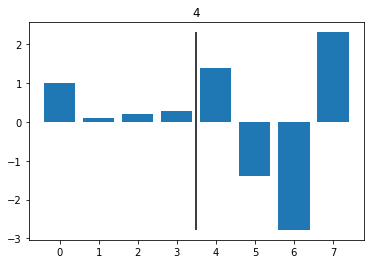

[[-0.23063913 -1.3796984   0.0237442  -0.44115475 -2.018855   -2.3253822
  -2.5125465   0.9820449 ]]


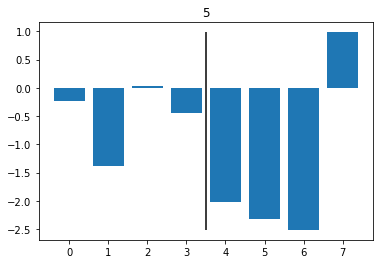

[[-0.4820222  -0.05065047 -0.5454165   1.014242   -1.9965922   0.89692473
   1.3868353   0.2370416 ]]


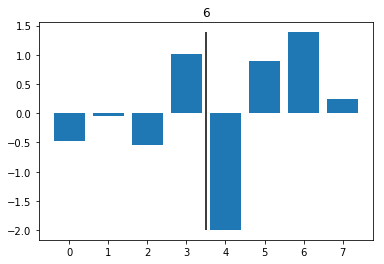

[[ 0.7648511  -0.45696965  0.04259017  1.4184759  -1.3642106  -2.2189317
   1.8036648  -1.5768167 ]]


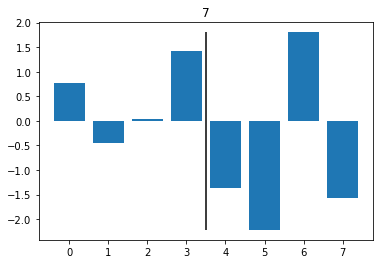

[[-1.738357    0.9896472   0.4054536  -0.02392689  0.8051083   0.1045567
   0.54708385 -2.0641348 ]]


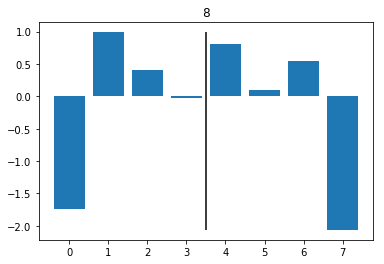

[[ 0.6547204  -1.2585914   0.9356145   0.03794168 -1.6572158  -1.822533
   1.8443506  -0.9156971 ]]


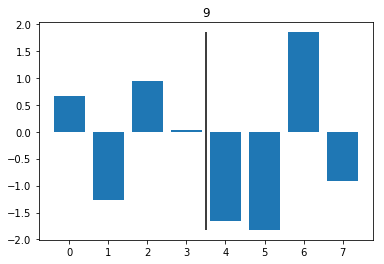

In [54]:
for i in range(n_specific):
    print(sep_mlp.out[i].W.data)
    plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
    ymax = sep_mlp.out[i].W.data.max()
    ymin = sep_mlp.out[i].W.data.min()
    plt.title(i)
    plt.vlines(n_col*n_row - .5 , ymin=ymin, ymax=ymax)
    plt.show()

In [20]:
sep_mlp.out[1].W

variable W([[ 0.2536435 ,  0.25699794, -0.35537377,  0.8589217 ,
             -0.34231865,  0.3147955 ,  0.2837925 , -0.22916302,
             -0.65419525,  0.2821943 , -0.3133061 , -0.34953964,
             -0.5245345 ,  0.613856  , -0.3837532 , -0.7158491 ,
             -0.29600126,  0.2790813 ]])